# LLMs e IA Generativa

## Agentes para chatbot de CVs

### Arquitectura ReWoo

In [ ]:
from typing import TypedDict
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END, START
from typing import List
import os
import re

from langchain_core.prompts import ChatPromptTemplate

from dotenv import load_dotenv

load_dotenv()

In [ ]:
# Inicializar un LLM base
ChatGroq.api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model_name="llama3-8b-8192")


In [3]:
class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

In [ ]:
class Agent:

    def __init__(self, model, search, prompt="", solve_prompt=""):

        self.search = search
        self.prompt = prompt
        self.solve_prompt = solve_prompt

        # Regex to match expressions of the form E#... = ...[...]
        self.regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
        prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
        self.planner = prompt_template | model

        graph = StateGraph(ReWOO)
        graph.add_node("plan", self.get_plan)
        graph.add_node("tool", self.tool_execution)
        graph.add_node("solve", self.solve)
        graph.add_edge("plan", "tool")
        graph.add_edge("solve", END)
        graph.add_conditional_edges("tool", self._route)
        graph.add_edge(START, "plan")

        self.app = graph.compile()
        self.model = model
        # self.model = model.bind_tools(tools) # from prev. example


    def get_plan(self, state: ReWOO):
        task = state["task"]
        result = self.planner.invoke({"task": task})
        # Find all matches in the sample text
        matches = re.findall(self.regex_pattern, result.content)
        return {"steps": matches, "plan_string": result.content}
    

    def tool_execution(self, state: ReWOO):
        """Worker node that executes the tools of a given plan."""
        _step = self._get_current_task(state)
        print("DEBUG")
        print("_step - 1: " + str(_step - 1))
        print("state['steps']: " + str(state['steps']))
        _, step_name, tool, tool_input = state["steps"][_step - 1]
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
        if tool == "Google":
            result = self.search.invoke(tool_input)
        elif tool == "LLM":
            result = self.model.invoke(tool_input)
        else:
            raise ValueError
        _results[step_name] = str(result)
        return {"results": _results}
    

    def solve(self, state: ReWOO):
        plan = ""
        for _plan, step_name, tool, tool_input in state["steps"]:
            _results = (state["results"] or {}) if "results" in state else {}
            for k, v in _results.items():
                tool_input = tool_input.replace(k, v)
                step_name = step_name.replace(k, v)
            plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
        prompt = self.solve_prompt.format(plan=plan, task=state["task"])
        result = self.model.invoke(prompt)
        return {"result": result.content}
    

    def _get_current_task(self, state: ReWOO):
        if "results" not in state or state["results"] is None:
            return 1
        if len(state["results"]) == len(state["steps"]):
            return None
        else:
            return len(state["results"]) + 1


    def _route(self, state: ReWOO):
        _step = self._get_current_task(state)
        if _step is None:
            # We have executed all tasks
            return "solve"
        else:
            # We are still executing tasks, loop back to the "tool" node
            return "tool"


In [ ]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

IMPORTANT: Tools can be ONLY one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

In general, the format must comply with the following regex: r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""

tavily_search = TavilySearchResults(tavily_api_key=os.getenv('TAVILY_API_KEY'),max_results=4) 


abot = Agent(llm, tavily_search, prompt, solve_prompt)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_35309/3759441340.py:1: SyntaxWarning: invalid escape sequence '\s'
  prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \


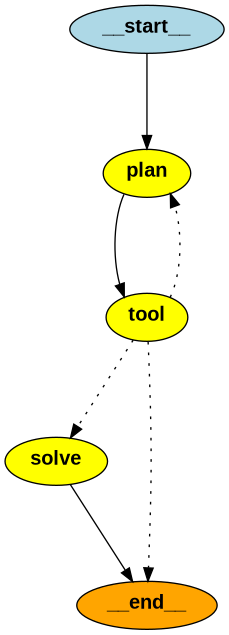

In [6]:
import pygraphviz
from IPython.display import Image

Image(abot.app.get_graph().draw_png())

In [7]:
task = "Describe how to build a rocket and tell me the weather in buenos aires"

for s in abot.app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': 'What a fascinating task! Here\'s a step-by-step plan to tackle the problem:\n\nPlan: Define the key components of a rocket and gather information on building one. #E1 = Google[What are the main components of a rocket?]\n\nThis plan uses the Google tool to search for information on the main components of a rocket. The input query is "What are the main components of a rocket?" This will provide a concise answer on the essential parts of a rocket, such as the fuel tanks, engines, guidance system, and payload.\n\nPlan: Using the information gathered, outline the general steps involved in building a rocket. #E2 = LLM[Outline the steps to build a rocket, given #E1]\n\nThis plan uses the LLM tool to provide a logical and structured approach to building a rocket, leveraging the information gathered from Google in the previous step. The LLM will use its general world knowledge and common sense to generate a step-by-step guide on how to build a rocket.\n\nPlan: Since th

In [8]:
# Print out the final result
print(s["solve"]["result"])

Here is the response:

To build a rocket, follow these steps: I. Structural System: Design the rocket body (fuselage), create the structural frame, and assemble the structural components. II. Propulsion System: Choose the propulsion method, design the combustion chamber and nozzle, select and prepare the working fluid, and assemble the propulsion components. III. Payload System: Determine the payload requirements, design the payload compartment, and assemble the payload components. IV. Guidance System: Determine the guidance requirements, design the guidance components, and assemble the guidance components. V. Integration and Testing: Integrate the structural, propulsion, payload, and guidance systems, conduct ground testing, and conduct flight testing.

The current weather in Buenos Aires is Clear, with a temperature of 24.0°C (75.2°F), wind speed of 8.5 km/h (5.3 mph), and humidity of 44%.
